# **Modeling**

In [ ]:
# Importar librerías
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve

from sklearn.model_selection import StratifiedKFold, cross_validate

In [ ]:
ubicacion_drive = '/content/drive/MyDrive/6672_Business Predictive Analytics_TF_Grupo 5/FuentesDatos'
df_modelo = pd.read_pickle(f'{ubicacion_drive}/df_transformado.pickle')

## **Train Test Split**

In [ ]:
X_train = df_modelo['X_train'] # Escalada + balanceo
y_train = df_modelo['y_train'] # Balanceo
X_test = df_modelo['X_test'] # Escalado y sin balanceo
y_test = df_modelo['y_test']

## **Cross Validation**

In [ ]:
# Configurar y función de validación cruzada
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

scoring = {
    'accuracy': 'accuracy',
    'precision': 'precision',
    'recall': 'recall',
    'f1': 'f1',
    'roc_auc': 'roc_auc'
}

def validacion_cruzada(nombre_modelo, modelo, X_train, y_train):
  cv_res = cross_validate(
    modelo,
    X_train,
    y_train,
    cv=cv,
    scoring=scoring,
    n_jobs=-1,
    return_train_score=False
  )

  resumen = {
    'Modelo': nombre_modelo,
    'Accuracy (cv mean)':  cv_res['test_accuracy'].mean(),
    'Precision (cv mean)': cv_res['test_precision'].mean(),
    'Recall (cv mean)':    cv_res['test_recall'].mean(),
    'F1 (cv mean)':        cv_res['test_f1'].mean(),
    'AUC (cv mean)':       cv_res['test_roc_auc'].mean()
  }

  df_resumen = pd.DataFrame(resumen, index=[0])
  display(df_resumen)

## **Evaluation Models**

In [ ]:
# Evaluación del modelo
def evaluar_modelo(nombre_modelo, modelo, X_test, y_test):
  y_pred  = modelo.predict(X_test)
  y_proba = modelo.predict_proba(X_test)[:, 1]

  acc  = accuracy_score(y_test, y_pred)
  prec = precision_score(y_test, y_pred, zero_division=0)
  rec  = recall_score(y_test, y_pred, zero_division=0)
  f1   = f1_score(y_test, y_pred, zero_division=0)
  auc  = roc_auc_score(y_test, y_proba)

  resumen = {
    'Modelo': nombre_modelo,
    'Accuracy': acc,
    'Precision': prec,
    'Recall': rec,
    'F1': f1,
    'AUC': auc
  }
  df_resumen = pd.DataFrame(resumen, index=[0])
  display(df_resumen)

  # Matriz de confusión
  cm = confusion_matrix(y_test, y_pred)

  plt.figure(figsize=(5,4))
  sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=['Predicción: No Falla (0)', 'Predicción: Falla (1)'],
    yticklabels=['Real: No Falla (0)', 'Real: Falla (1)']
  )
  plt.title(f"Matriz de Confusión - {nombre_modelo}")
  plt.ylabel("Valor real")
  plt.xlabel("Predicción del modelo");

  return {
        "Modelo": nombre_modelo,
        "Accuracy": acc,
        "Precision": prec,
        "Recall": rec,
        "F1": f1,
        "AUC": auc,
        "y_proba": y_proba
    }

In [ ]:
# Gráficar ROC
def graficar_roc(nombre_modelo, y_test, y_proba):
  fpr, tpr, _ = roc_curve(y_test, y_proba)
  auc_val = roc_auc_score(y_test, y_proba)

  plt.figure(figsize=(6,5))
  plt.plot(fpr, tpr, label=f'{nombre_modelo} (AUC = {auc_val:.3f})')
  plt.plot([0,1], [0,1], 'k--')

  plt.title(f'Curva ROC - {nombre_modelo}')
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.legend()
  plt.grid(True);

## **Modelos**

### **Regresión Logística**

In [ ]:
# Instanciar modelo de Regresión Logística
modelo_RegLog = LogisticRegression(
    random_state=42
)

In [ ]:
# Validación Cruzada
validacion_cruzada("Regresión Logística", modelo_RegLog, X_train, y_train)

,Modelo,Accuracy (cv mean),Precision (cv mean),Recall (cv mean),F1 (cv mean),AUC (cv mean)
0,Regresión Logística,0.741805,0.696704,0.856493,0.768372,0.773507


In [ ]:
# Entrenamiento del modelo
modelo_RegLog.fit(X_train, y_train)

LogisticRegression(random_state=42)

In [ ]:
# Predicciones
y_pred_reglog = modelo_RegLog.predict(X_test)
y_pred_proba_reglog = modelo_RegLog.predict_proba(X_test)

df_pred_reglog = pd.DataFrame({
    "Real (DTC)": y_test.values,
    "Predicción": y_pred_reglog,
    "Probabilidad de Falla": y_pred_proba_reglog[:, 1]
})

df_pred_reglog.head(10)

,Real (DTC),Predicción,Probabilidad de Falla
0,0,1,0.557541
1,0,1,0.543972
2,0,0,0.212472
3,0,1,0.728943
4,0,1,0.751183
5,0,0,0.084638
6,0,0,0.020156
7,0,0,0.419792
8,0,0,0.189993
9,0,0,0.053046


,Modelo,Accuracy,Precision,Recall,F1,AUC
0,Regresión Logística,0.63984,0.061145,0.842324,0.114013,0.768254


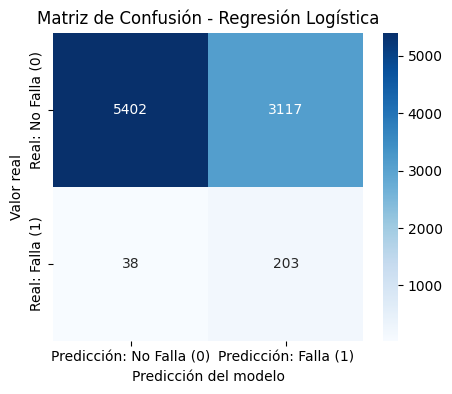

In [ ]:
# Evaluar modelo
rgl_res = evaluar_modelo("Regresión Logística", modelo_RegLog, X_test, y_test)

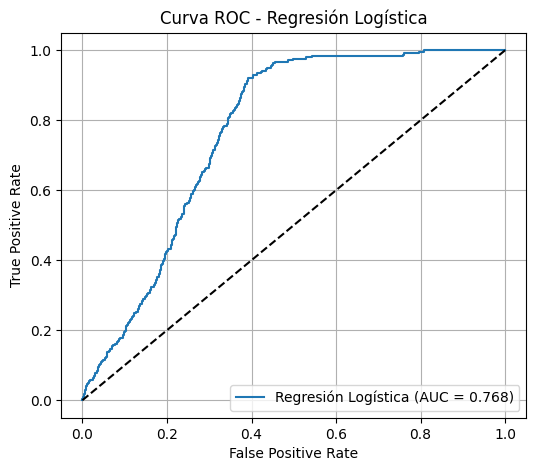

In [ ]:
# Graficar ROC
probabilidades = modelo_RegLog.predict_proba(X_test)[:, 1]
graficar_roc("Regresión Logística", y_test, probabilidades)

### **Random Forest**

In [ ]:
# Instanciar modelo de Random Forest
modelo_RandomForest = RandomForestClassifier(
    random_state=42,
)

In [ ]:
# Validación Cruzada
validacion_cruzada("Random Forest", modelo_RandomForest, X_train, y_train)

,Modelo,Accuracy (cv mean),Precision (cv mean),Recall (cv mean),F1 (cv mean),AUC (cv mean)
0,Random Forest,0.996522,0.998,0.99504,0.996517,0.999916


In [ ]:
# Entrenamiento del modelo
modelo_RandomForest.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [ ]:
# Predicciones
y_pred_random_forest = modelo_RandomForest.predict(X_test)
y_pred_proba_random_forest = modelo_RandomForest.predict_proba(X_test)[:, 1]

df_pred_random_forest = pd.DataFrame({
    "Real (DTC)": y_test.values,
    "Predicción": y_pred_random_forest,
    "Probabilidad de Falla": y_pred_proba_random_forest
})

df_pred_random_forest.head(10)

,Real (DTC),Predicción,Probabilidad de Falla
0,0,0,0.00
1,0,0,0.00
2,0,0,0.00
3,0,0,0.01
4,0,0,0.02
5,0,0,0.00
6,0,0,0.00
7,0,0,0.02
8,0,0,0.00
9,0,0,0.00


,Modelo,Accuracy,Precision,Recall,F1,AUC
0,Random Forest,0.997146,0.915385,0.987552,0.9501,0.997254


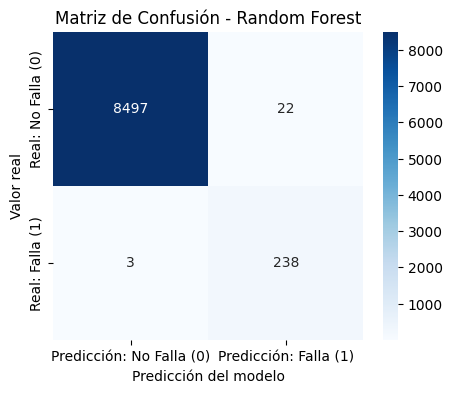

In [ ]:
# Evaluar modelo
rfr_res = evaluar_modelo("Random Forest", modelo_RandomForest, X_test, y_test)

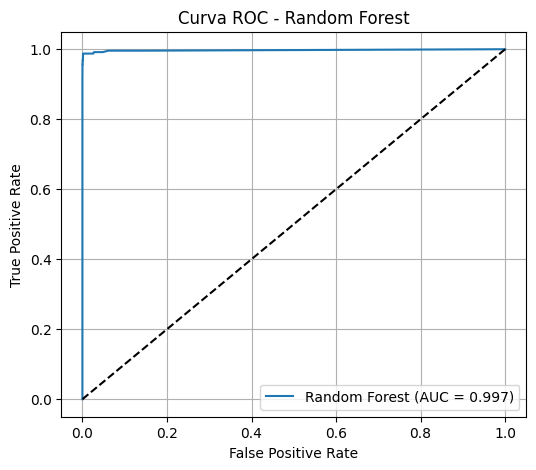

In [ ]:
# Graficar ROC
probabilidades = modelo_RandomForest.predict_proba(X_test)[:, 1]
graficar_roc("Random Forest", y_test, probabilidades)

### **XGBoost**

In [ ]:
# Instanciar modelo de XGBoost
modelo_XGBoost = XGBClassifier(
    random_state=42
)

In [ ]:
# Validación Cruzada
validacion_cruzada("XGBoost", modelo_XGBoost, X_train, y_train)

,Modelo,Accuracy (cv mean),Precision (cv mean),Recall (cv mean),F1 (cv mean),AUC (cv mean)
0,XGBoost,0.997168,0.996979,0.997359,0.997169,0.999907


In [ ]:
# Entrenamiento del modelo
modelo_XGBoost.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, ...)

In [ ]:
# Predicciones
y_pred_XGBoost = modelo_XGBoost.predict(X_test)
y_pred_proba_XGBoost = modelo_XGBoost.predict_proba(X_test)[:, 1]

df_pred_XGBoost = pd.DataFrame({
    "Real (DTC)": y_test.values,
    "Predicción": y_pred_XGBoost,
    "Probabilidad de Falla": y_pred_proba_XGBoost
})

df_pred_XGBoost.head(10)

,Real (DTC),Predicción,Probabilidad de Falla
0,0,0,0.003600
1,0,0,0.000003
2,0,0,0.000021
3,0,0,0.000431
4,0,1,0.887784
5,0,0,0.000100
6,0,0,0.000004
7,0,0,0.000038
8,0,0,0.000320
9,0,0,0.000015


,Modelo,Accuracy,Precision,Recall,F1,AUC
0,XGBoost,0.994406,0.877953,0.925311,0.90101,0.99345


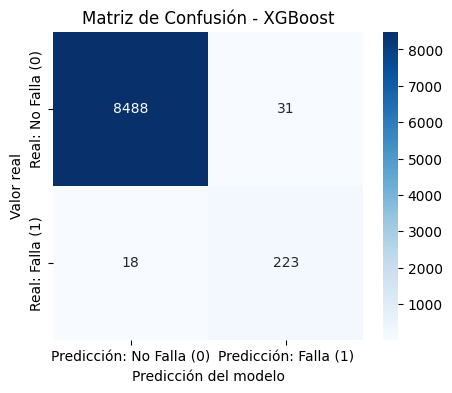

In [ ]:
# Evaluar modelo
xgb_res = evaluar_modelo("XGBoost", modelo_XGBoost, X_test, y_test)

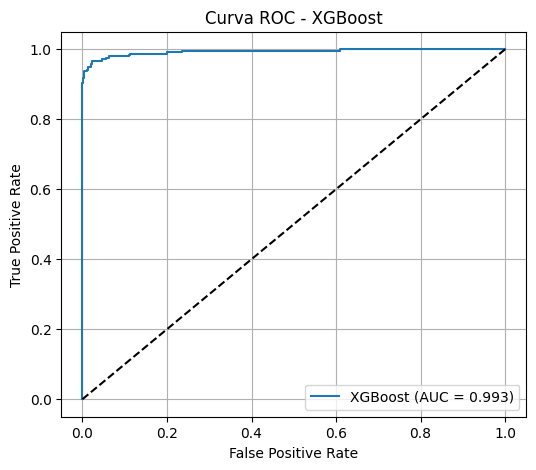

In [ ]:
# Graficar ROC
probabilidades = modelo_XGBoost.predict_proba(X_test)[:, 1]
graficar_roc("XGBoost", y_test, probabilidades)

In [ ]:
# Probabilidades de falla (clase 1) para cada modelo
y_proba_reglog = modelo_RegLog.predict_proba(X_test)[:, 1]
y_proba_rf     = modelo_RandomForest.predict_proba(X_test)[:, 1]
y_proba_xgb    = modelo_XGBoost.predict_proba(X_test)[:, 1]

In [ ]:
# Diccionario maestro para recorrer todos los modelos
modelos_info = {
  "Regresión Logística": {
    "y_pred":  y_pred_reglog,
    "y_proba": y_proba_reglog
  },
  "Random Forest": {
    "y_pred":  y_pred_random_forest,
    "y_proba": y_proba_rf
  },
  "XGBoost": {
    "y_pred":  y_pred_XGBoost,
    "y_proba": y_proba_xgb
  }
}

filas_metricas = []
filas_roc = []
filas_cm = []

for nombre_modelo, datos in modelos_info.items():
  y_pred  = datos["y_pred"]
  y_proba = datos["y_proba"]

  acc  = accuracy_score(y_test, y_pred)
  prec = precision_score(y_test, y_pred, zero_division=0)
  rec  = recall_score(y_test, y_pred, zero_division=0)
  f1   = f1_score(y_test, y_pred, zero_division=0)
  auc  = roc_auc_score(y_test, y_proba)

  filas_metricas.append({
    "Modelo": nombre_modelo,
    "Accuracy": acc,
    "Precision": prec,
    "Recall": rec,
    "F1": f1,
    "AUC": auc
  })

  fpr, tpr, thresholds = roc_curve(y_test, y_proba)

  for fp, tp, thr in zip(fpr, tpr, thresholds):
    filas_roc.append({
      "Modelo": nombre_modelo,
      "FPR": fp,
      "TPR": tp,
      "Threshold": thr
    })

  cm = confusion_matrix(y_test, y_pred)
  for real in [0, 1]:
    for pred in [0, 1]:
      filas_cm.append({
        "Modelo": nombre_modelo,
        "Clase_real": real,
        "Clase_predicha": pred,
        "Conteo": int(cm[real, pred])
      })

# DataFrames finales
df_metricas_modelos = pd.DataFrame(filas_metricas)
df_roc_modelos = pd.DataFrame(filas_roc)
df_cm_modelos = pd.DataFrame(filas_cm)

# Exportar a CSV para Power BI
df_metricas_modelos.to_csv("modelos_metricas.csv", index=False)
df_roc_modelos.to_csv("modelos_curvas_roc.csv", index=False)
df_cm_modelos.to_csv("modelos_matrices_confusion.csv", index=False)

# **Optimization**

In [ ]:
# Importar librerías
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve

# Importar algoritmo
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, StratifiedKFold

,Modelo,Accuracy,Precision,Recall,F1,AUC
0,XGBoost - Base,0.994406,0.877953,0.925311,0.90101,0.99345


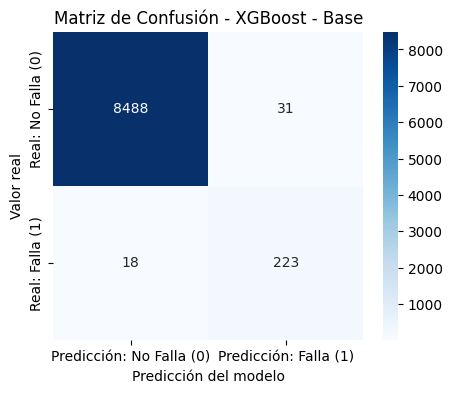

In [ ]:
# Instanciar modelo base de XGBoost
xgb_base = XGBClassifier(
  random_state=42
)

# Entrenamiento del modelo
xgb_base.fit(X_train, y_train)

# Evaluación del modelo
res_base = evaluar_modelo("XGBoost - Base", xgb_base, X_test, y_test)

## **GridSearchCV**


=== Ejecutando GridSearchCV ===
Fitting 3 folds for each of 64 candidates, totalling 192 fits

=== Mejores hiperparámetros (GridSearchCV): ===
{'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 0.8}

Mejor AUC (cv): 0.9999



,Modelo,Accuracy,Precision,Recall,F1,AUC
0,XGBoost - GridSearchCV,0.99395,0.864341,0.925311,0.893788,0.993984


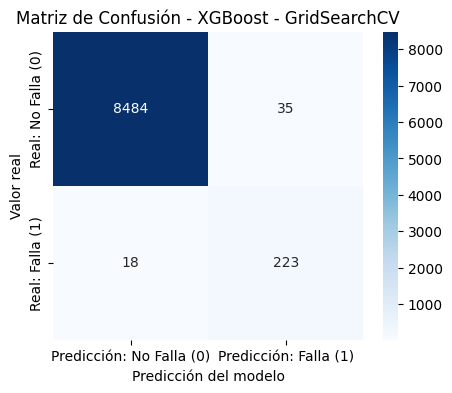

In [ ]:
param_grid_gs = {
  'max_depth':        [4, 6],
  'learning_rate':    [0.05, 0.1],
  'n_estimators':     [200, 300],
  'subsample':        [0.8],
  'colsample_bytree': [0.8, 1.0],
  'gamma':            [0, 1],
  'min_child_weight': [1, 5]
}

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

grid_search = GridSearchCV(
  estimator=xgb_base,
  param_grid=param_grid_gs,
  scoring='roc_auc',
  cv=cv,
  n_jobs=-1,
  verbose=1
)

print('\n=== Ejecutando GridSearchCV ===')
grid_search.fit(X_train, y_train)

print('\n=== Mejores hiperparámetros (GridSearchCV): ===')
print(grid_search.best_params_)
print(f'\nMejor AUC (cv): {grid_search.best_score_:.4f}\n')

xgb_gs = grid_search.best_estimator_
res_gs = evaluar_modelo('XGBoost - GridSearchCV', xgb_gs, X_test, y_test)

## **RandomSearchCV**


=== Ejecutando RandomizedSearchCV ===
Fitting 3 folds for each of 30 candidates, totalling 90 fits

=== Mejores hiperparámetros (RandomizedSearchCV) ===
{'subsample': 0.6, 'n_estimators': 500, 'min_child_weight': 1, 'max_depth': 8, 'learning_rate': 0.05, 'gamma': 0.5, 'colsample_bytree': 0.6}

Mejor AUC (cv): 0.9999



,Modelo,Accuracy,Precision,Recall,F1,AUC
0,XGBoost - RandomizedSearchCV,0.994406,0.877953,0.925311,0.90101,0.994746


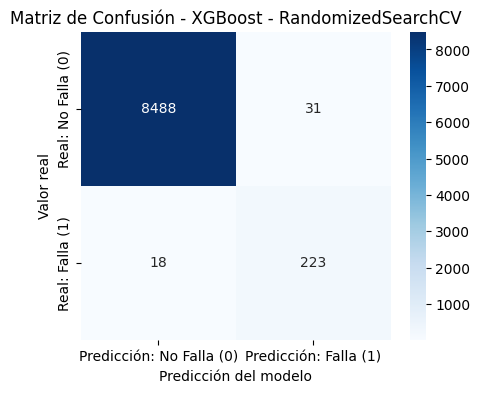

In [ ]:
param_dist_rs = {
  'max_depth':        [3, 4, 5, 6, 8, 10],
  'learning_rate':    [0.005, 0.01, 0.03, 0.05, 0.1],
  'n_estimators':     [150, 200, 250, 300, 400, 500],
  'subsample':        [0.6, 0.7, 0.8, 0.9, 1.0],
  'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0],
  'gamma':            [0, 0.5, 1, 2, 5, 10],
  'min_child_weight': [1, 3, 5, 7]
}

random_search = RandomizedSearchCV(
  estimator=xgb_base,
  param_distributions=param_dist_rs,
  n_iter=30,
  scoring='roc_auc',
  cv=cv,
  n_jobs=-1,
  verbose=1,
  random_state=42
)

print('\n=== Ejecutando RandomizedSearchCV ===')
random_search.fit(X_train, y_train)

print('\n=== Mejores hiperparámetros (RandomizedSearchCV) ===')
print(random_search.best_params_)
print(f'\nMejor AUC (cv): {random_search.best_score_:.4f}\n')

xgb_rs = random_search.best_estimator_
res_rs = evaluar_modelo('XGBoost - RandomizedSearchCV', xgb_rs, X_test, y_test)


## **Comparativa**

In [ ]:
# Comparativa de los resultado de métricas
resultados = []

for res in [res_base, res_gs, res_rs]:
    resultados.append({
        "Modelo":  res["Modelo"],
        "Accuracy": res["Accuracy"],
        "Precision": res["Precision"],
        "Recall": res["Recall"],
        "F1": res["F1"],
        "AUC": res["AUC"]
    })

df_resultados = pd.DataFrame(resultados)
print("\nComparación de modelos XGBoost (Base vs GridSearch vs Randomized):")
display(df_resultados.sort_values("AUC", ascending=False))



Comparación de modelos XGBoost (Base vs GridSearch vs Randomized):


,Modelo,Accuracy,Precision,Recall,F1,AUC
2,XGBoost - RandomizedSearchCV,0.994406,0.877953,0.925311,0.901010,0.994746
1,XGBoost - GridSearchCV,0.993950,0.864341,0.925311,0.893788,0.993984
0,XGBoost - Base,0.994406,0.877953,0.925311,0.901010,0.993450


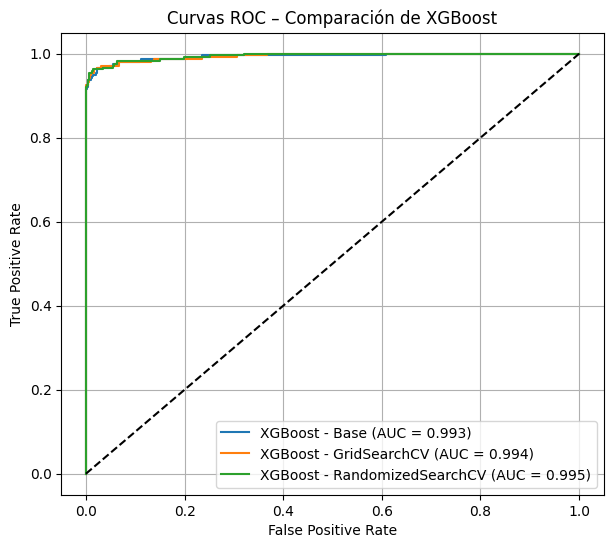

In [ ]:
# Comparativa con curvas de ROC
plt.figure(figsize=(7, 6))

for res, color in zip(
    [res_base, res_gs, res_rs],
    ['C0', 'C1', 'C2']
):
    fpr, tpr, _ = roc_curve(y_test, res["y_proba"])
    plt.plot(fpr, tpr, label=f"{res['Modelo']} (AUC = {res['AUC']:.3f})")

plt.plot([0,1], [0,1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Curvas ROC – Comparación de XGBoost")
plt.legend()
plt.grid(True);

In [ ]:
# Datos de Prueba para test

# Importar librerías
from sklearn.model_selection import train_test_split
_, X_test_raw, _, y_test_raw = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Cargar df_transformado
df_modelo = pd.read_pickle('df_transformado.pickle')

# Separar los datos de prueba
X_test_original = df_modelo['X_test']
y_test_original = df_modelo['y_test']

# Cargar df_eda
df_eda = pd.read_pickle('df_eda.pickle')

# Reconstruimos el test set sin escalar:
X = df_eda.drop(columns='DTC')
y = df_eda['DTC']

# Seleccionar casos reales de fallo y no fallo
casos_falla = X_test_raw[y_test_raw == 1].sample(3, random_state=42)
casos_no_falla = X_test_raw[y_test_raw == 0].sample(3, random_state=42)

# Unimos ambos
X_test_custom = pd.concat([casos_falla, casos_no_falla], ignore_index=True)

# Agregar target real
y_real = pd.concat([
    y_test_raw[y_test_raw == 1].sample(3, random_state=42),
    y_test_raw[y_test_raw == 0].sample(3, random_state=42)
], ignore_index=True)

# Escalar con el mismo scaler
X_test_custom_scaled = scaler.transform(X_test_custom)
X_test_custom_scaled = pd.DataFrame(X_test_custom_scaled, columns=X_test_custom.columns)

# Predecir
proba = xgb_rs.predict_proba(X_test_custom_scaled)[:, 1]
pred = xgb_rs.predict(X_test_custom_scaled)

# Mostrar resultados
df_resultados = X_test_custom.copy()
df_resultados["DTC_real"] = y_real.values
df_resultados["Prob_falla"] = proba
df_resultados["Predicción"] = pred
df_resultados["Nivel_riesgo"] = df_resultados["Prob_falla"].apply(
    lambda p: "Alto" if p >= 0.7 else ("Medio" if p >= 0.3 else "Bajo")
)

print("\n=== Resultados reales del dataset (sin NaN) ===")
display(df_resultados)



=== Resultados reales del dataset (sin NaN) ===


,SOC,SOH,charging_cycles,battery_temp,motor_rpm,motor_torque,motor_temp,brake_pad_wear,tire_pressure,DTC_real,Prob_falla,Predicción,Nivel_riesgo
0,57.680357,99.612262,13,34.904609,1240.193235,248.038647,78.652297,65.032221,30.192413,1,0.000939,0,Bajo
1,76.318288,95.743988,35,32.389693,1338.438328,267.687666,69.176393,74.836020,31.810737,1,0.998984,1,Alto
2,63.740128,97.631241,79,41.368465,1397.935188,279.587038,65.341870,34.237257,25.932071,1,0.999961,1,Alto
3,92.984519,97.640278,79,41.003008,1510.808402,302.161680,64.295080,34.402553,26.226005,0,0.001251,0,Bajo
4,90.642274,90.530216,16,31.296749,0.000000,0.000000,65.977194,63.962166,29.205439,0,0.000281,0,Bajo
5,50.136470,99.228369,26,37.668115,4399.522550,879.904510,96.225334,88.001721,29.898288,0,0.000039,0,Bajo


In [ ]:
# Importar modelo de ML
import pickle
archivo = f'{ubicacion_drive}/modelo_final_xgboost.sav'
pickle.dump(xgb_rs, open(archivo, 'wb'))